# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [1]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
# from xhistogram.xarray import histogram

In [2]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [3]:
# parameters
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

interim_data_path = Path('data/interim/')

sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

figure_path = Path('reports/figures/subsets/')

year = 2000
# output figures path
figures_path = Path("reports/figures/ColdBlob/")

In [4]:
# data_stores_subsets = list(sorted(Path(data_path).glob("*_????_subset.zarr/")))[:use_number_subset_years]
data_trackends_subsets = list(sorted(Path(project_path / interim_data_path).glob("*2021*_10percent.nc/")))


In [5]:
display(data_trackends_subsets)

[PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_20210817_randomvel_mxl_osnap_backwards_1990_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_20210817_randomvel_mxl_osnap_backwards_1991_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_20210817_randomvel_mxl_osnap_backwards_1992_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_20210817_randomvel_mxl_osnap_backwards_1993_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_20210817_randomvel_mxl_osnap_backwards_1994_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects/spg_fresh_blob_202104/data/interim/endtracks_20210817_randomvel_mxl_osnap_backwards_1995_subset_10percent.nc'),
 PosixPath('/home/jupyter-workshop007/Projects

In [6]:

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file =  project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 2375914.29783   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 1000 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * 2100000 / 2643886

# this is to compensate for not using all the particles. 1 in 10 particles selected.
subset = 0.1

max_current = 2.0

particle_section_area = max_current * osnap_subsection_length * osnap_subsection_depth / (2643886 * subset)

## Load data

### mesh and masks

In [7]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

### section position data

In [8]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

In [9]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

In [10]:
lonlat

<xarray.Dataset>
Dimensions:  (dim_0: 13)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lat      (dim_0) float64 52.09 52.67 53.59 59.11 ... 57.99 57.47 57.1 56.73
    lon      (dim_0) float64 -56.16 -52.1 -49.78 -47.34 ... -12.71 -9.275 -5.77

### tracks

In [11]:
for i,filename in enumerate(data_trackends_subsets[0:None]):
#     dst=xr.open_dataset(project_path / interim_data_path / filename,chunks={"traj":400000})
    dst=xr.open_dataset(project_path / interim_data_path / filename)
    if i == 0:
        ds=dst
    else:
        ds=xr.concat([ds,dst],dim='traj')


In [12]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 14143053)
Dimensions without coordinates: ends, traj
Data variables: (12/17)
    lat              (ends, traj) float32 59.83 60.07 60.07 ... 29.82 36.19
    lon              (ends, traj) float32 -45.38 -42.84 -42.86 ... -79.99 -14.91
    mxl              (ends, traj) float32 31.62 28.04 28.04 ... 23.15 78.34
    salt             (ends, traj) float32 33.68 33.53 33.62 ... 36.47 35.64
    temp             (ends, traj) float32 0.6559 0.125 0.4715 ... 25.12 12.66
    time             (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 2009...
    ...               ...
    LCdir_is_path    (ends, traj) bool True False False ... False False False
    GulfS_is_source  (ends, traj) bool False False False ... False True False
    other_is_source  (ends, traj) bool False True True True ... True False True
    Green_is_source  (ends, traj) bool False False False ... False False False
    Davis_is_source  (ends, traj) bool False False False ... False False False
    north_of_osnap   (ends, traj) bool True True True True ... False True False
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [13]:
t=[]
length=[]

for name,group in ds.isel(ends=0).groupby(ds.isel(ends=0).time):
    t.append(name)
    length.append(group.lat.shape[0])
    

#### Subset tracks by OSNAP line cross longitude and depth range

In [14]:
lonRange=[-37,0]
depthRange=[0,500]
range_str = 'OsnapE_test'

In [15]:
ds = ds.where((ds.isel(ends=0).lon > lonRange[0]) & (ds.isel(ends=0).lon < lonRange[1]))
ds = ds.where((ds.isel(ends=0).z > depthRange[0]) & (ds.isel(ends=0).z < depthRange[1]))
ds = ds.dropna('traj', how='all')
    

#### Add density (sigma0) to variables

In [16]:
ds = ds.assign({'sigma0':xr.DataArray(sw.dens(ds.salt,ds.temp,0) - 1000.0,dims=('ends','traj'))})
ds.sigma0.attrs = {'units':'kg/m3','long_name':'potential density $\sigma_0$'}

subset by density

In [17]:
ds = ds.where((ds.isel(ends=0).sigma0 < 50))
ds = ds.dropna('traj', how='all')

#### Velocity conversions from degrees lat/lon per second to m/s

In [18]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

In [31]:
ds = ds.assign({'section_index':(ds.isel(ends=0).lon > lonlat.lon).sum(dim='dim_0')-1})
ds = ds.assign({'u_normal':ds.isel(ends=0).vvel_ms * lonlatdiff.costheta[ds.section_index].data - ds.isel(ends=0).uvel_ms * lonlatdiff.sintheta[ds.section_index].data})
ds = ds.assign({'u_along':ds.isel(ends=0).vvel_ms * lonlatdiff.sintheta[ds.section_index].data + ds.isel(ends=0).uvel_ms * lonlatdiff.costheta[ds.section_index].data})


In [32]:
ds

<xarray.Dataset>
Dimensions:          (ends: 2, traj: 6604481)
Dimensions without coordinates: ends, traj
Data variables: (12/23)
    lat              (ends, traj) float32 59.01 59.04 59.32 ... 29.82 36.19
    lon              (ends, traj) float32 -32.55 -32.83 -35.54 ... -79.99 -14.91
    mxl              (ends, traj) float32 338.1 337.1 207.0 ... 23.15 78.34
    salt             (ends, traj) float32 35.12 35.1 34.93 ... 35.61 36.47 35.64
    temp             (ends, traj) float32 7.324 6.744 5.838 ... 25.12 12.66
    time             (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 2009...
    ...               ...
    sigma0           (ends, traj) float32 27.47 27.54 27.52 ... 24.42 26.95
    uvel_ms          (ends, traj) float32 0.0286 0.0209 ... 0.03964 0.05353
    vvel_ms          (ends, traj) float32 0.04885 0.02625 ... 1.441 -0.02351
    section_index    (traj) int64 5 5 5 5 5 5 5 5 5 ... 11 11 11 11 11 11 11 11
    u_normal         (traj) float64 0.05356 0.02988 0.09683 ... 0.1081 0.1164
    u_along          (traj) float64 0.01834 0.01528 0.02201 ... -0.06058 0.02719
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

In [1]:
test=np.searchsorted(lonlat.lon,ds.isel(ends=0).lon)

NameError: name 'np' is not defined

In [30]:
(test - (ds.isel(ends=0).lon > lonlat.lon).sum(dim='dim_0')).sum()

<xarray.DataArray 'lon' ()>
array(0)
Attributes:
    axis:           X
    long_name:      
    standard_name:  longitude
    units:          degrees_east

#### Find along-section distances of initial points

In [2]:
lonlat.lon

NameError: name 'lonlat' is not defined

In [29]:
ds = ds.assign({'x':xr.DataArray(length_west[ds.section_index] + lonlatdiff.length[ds.section_index]*
                              (ds.isel(ends=0).lon - lonlat.lon[ds.section_index])/lonlatdiff.lon[ds.section_index],dims='traj')})

### volume, temperature and salt transports along track

In [30]:
# at osnap line
ds = ds.assign({'vol_trans_normal':np.sign(ds.u_normal) * particle_section_area/1.0e06})
ds = ds.assign({'particle_vol':ds.vol_trans_normal/ds.u_normal})

#### Temporary fix for particle numbers in subset, based on constant total particle volume (basically area of section, use annual total)

In [31]:
# tcf = ds.isel(ends=0).groupby(ds.isel(ends=0).time.astype('datetime64[Y]')).sum().particle_vol
# tcf = tcf/(tcf.mean())
# tindex = ds.time.dt.year - 1990
# transport_correction_factor = np.array([tcf.data[i] for i in tindex])
# ds['vol_trans_normal'] = ds.vol_trans_normal/transport_correction_factor[0,:]
# ds['particle_vol'] = ds.particle_vol/transport_correction_factor[0,:]

In [32]:
# at osnap line
ds = ds.assign({'temp_transport':ds.temp * ds.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds.vol_trans_normal})
ds = ds.assign({'depth_transport':ds.z * ds.vol_trans_normal})
ds = ds.assign({'lon_transport':ds.lon * ds.vol_trans_normal})
ds = ds.assign({'tempxvol':ds.temp * ds.particle_vol})
ds = ds.assign({'saltxvol':ds.salt * ds.particle_vol})
ds = ds.assign({'depthxvol':ds.z * ds.particle_vol})
ds = ds.assign({'lonxvol':ds.lon * ds.particle_vol})


In [33]:
ds

<xarray.Dataset>
Dimensions:           (ends: 2, traj: 6604481)
Dimensions without coordinates: ends, traj
Data variables: (12/34)
    lat               (ends, traj) float32 59.01 59.04 59.32 ... 29.82 36.19
    lon               (ends, traj) float32 -32.55 -32.83 ... -79.99 -14.91
    mxl               (ends, traj) float32 338.1 337.1 207.0 ... 23.15 78.34
    salt              (ends, traj) float32 35.12 35.1 34.93 ... 36.47 35.64
    temp              (ends, traj) float32 7.324 6.744 5.838 ... 25.12 12.66
    time              (ends, traj) datetime64[ns] 1990-01-03T12:00:00 ... 200...
    ...                ...
    depth_transport   (ends, traj) float64 3.546 8.01 3.722 ... 1.318 5.197
    lon_transport     (ends, traj) float64 -0.585 -0.59 ... -1.438 -0.268
    tempxvol          (ends, traj) float64 2.458 4.057 1.084 ... 4.179 1.954
    saltxvol          (ends, traj) float64 11.79 21.12 6.484 ... 6.067 5.501
    depthxvol         (ends, traj) float64 66.2 268.1 38.44 ... 12.68 12.2 44.64
    lonxvol           (ends, traj) float64 -10.92 -19.75 -6.596 ... -13.3 -2.301
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.2.2

## Plot section

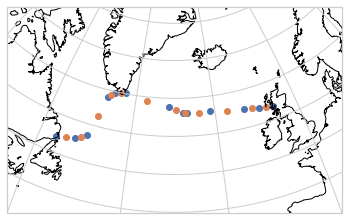

In [34]:
sns.set(style="whitegrid")
central_lon, central_lat = -30, 55
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
extent = [-60, 0, 40, 70]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')

lonlat.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat')
lonlat2mean.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat');

In [35]:
t=[]
length=[]

for name,group in ds.isel(ends=0).groupby(ds.isel(ends=0).time):
    t.append(name)
    length.append(group.lat.shape[0])
    

In [36]:
def plot_transports_by_source(total,labcu,gulfs,other,figname):
    
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)
    
    total.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C0',zorder=1)
    labcu.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C1',zorder=1)
    gulfs.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C2',zorder=1)
    other.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C3',zorder=1)
    total.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C0',zorder=10,label='total')
    labcu.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C1',zorder=10,label='labrador sea')
    gulfs.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C2',zorder=10,label='gulf stream')
    other.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C3',zorder=10,label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
#     ax[0].set_ylim(bottom=0)

    total.temp_transport.plot(ax=ax[1],alpha=0.4,color='C0',zorder=1)
    labcu.temp_transport.plot(ax=ax[1],alpha=0.4,color='C1',zorder=1)
    gulfs.temp_transport.plot(ax=ax[1],alpha=0.4,color='C2',zorder=1)
    other.temp_transport.plot(ax=ax[1],alpha=0.4,color='C3',zorder=1)
    total.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C0',zorder=10,label='total')
    labcu.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C1',zorder=10,label='labrador sea')
    gulfs.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C2',zorder=10,label='gulf stream')
    other.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C3',zorder=10,label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')
#     ax[1].set_ylim(bottom=0)

    total.salt_transport.plot(ax=ax[2],alpha=0.4,color='C0',zorder=1)
    labcu.salt_transport.plot(ax=ax[2],alpha=0.4,color='C1',zorder=1)
    gulfs.salt_transport.plot(ax=ax[2],alpha=0.4,color='C2',zorder=1)
    other.salt_transport.plot(ax=ax[2],alpha=0.4,color='C3',zorder=1)
    total.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C0',zorder=10,label='total')
    labcu.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C1',zorder=10,label='labrador sea')
    gulfs.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C2',zorder=10,label='gulf stream')
    other.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C3',zorder=10,label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
#     ax[2].set_ylim(bottom=0)

#     plt.tight_layout()

#     title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [37]:
def plot_total_transport(total,figname):
    
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(1,figsize = (9,7),sharex=True)
    
    total.vol_trans_normal.plot(ax=ax,alpha=0.4,color='C0',zorder=1)
    total.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax,color='C0',zorder=10,label='total')
    lgd = ax.legend(bbox_to_anchor=(1.0, 1.01),loc='upper left')
    ax.set_ylabel('transport [Sv]')
    ax.set_xlabel('time')
#     ax[0].set_ylim(bottom=0)

    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [38]:
def plot_transport_anomalies_by_source(total,labcu,gulfs,other,figname):

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)

    (total.vol_trans_normal - 
     total.vol_trans_normal.mean()).rolling(time=18,center=True).mean().plot(ax=ax[0],label='total')
    (labcu.vol_trans_normal-
     labcu.vol_trans_normal.mean()).rolling(time=18,center=True).mean().plot(ax=ax[0],label='labrador sea')
    (gulfs.vol_trans_normal-
     gulfs.vol_trans_normal.mean()).rolling(time=18,center=True).mean().plot(ax=ax[0],label='gulf stream')
    (other.vol_trans_normal-
     other.vol_trans_normal.mean()).rolling(time=18,center=True).mean().plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')

    (total.temp_transport-
     total.temp_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[1],label='total')
    (labcu.temp_transport-
     labcu.temp_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[1],label='labrador sea')
    (gulfs.temp_transport-
     gulfs.temp_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[1],label='gulf stream')
    (other.temp_transport-
     other.temp_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')

    (total.salt_transport-
     total.salt_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[2],label='total')
    (labcu.salt_transport-
     labcu.salt_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[2],label='labrador sea')
    (gulfs.salt_transport-
     gulfs.salt_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[2],label='gulf stream')
    (other.salt_transport-
     other.salt_transport.mean()).rolling(time=18,center=True).mean().plot(ax=ax[2],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
   

#     title=fig.suptitle('Transport anomalies across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [ ]:
total_sum  = ds.isel(ends=0).groupby("time").sum()
labcu_sum  = ds.isel(ends=0).where(ds.isel(ends=0).LabCu_is_source).groupby("time").sum()
gulfs_sum  = ds.isel(ends=0).where(ds.isel(ends=0).GulfS_is_source).groupby("time").sum()
other_sum  = ds.isel(ends=0).where(ds.isel(ends=0).other_is_source).groupby("time").sum()
total_mean = ds.isel(ends=0).groupby("time").mean()
labcu_mean = ds.isel(ends=0).where(ds.isel(ends=0).LabCu_is_source).groupby("time").mean()
gulfs_mean = ds.isel(ends=0).where(ds.isel(ends=0).GulfS_is_source).groupby("time").mean()
other_mean = ds.isel(ends=0).where(ds.isel(ends=0).other_is_source).groupby("time").mean()

lc60w_sum  = ds.isel(ends=0).where(ds.isel(ends=0).LC60W_is_path).groupby("time").sum()
lcdir_sum  = ds.isel(ends=0).where(ds.isel(ends=0).LCdir_is_path).groupby("time").sum()
lc60w_mean = ds.isel(ends=0).where(ds.isel(ends=0).LC60W_is_path).groupby("time").mean()
lcdir_mean = ds.isel(ends=0).where(ds.isel(ends=0).LCdir_is_path).groupby("time").mean()



In [ ]:
total_sum_1  = ds.isel(ends=1).groupby(ds.isel(ends=0).time).sum()
labcu_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).LabCu_is_source).groupby(ds.isel(ends=0).time).sum()
gulfs_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).GulfS_is_source).groupby(ds.isel(ends=0).time).sum()
other_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).other_is_source).groupby(ds.isel(ends=0).time).sum()
total_mean_1 = ds.isel(ends=1).groupby(ds.isel(ends=0).time).mean()
labcu_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).LabCu_is_source).groupby(ds.isel(ends=0).time).mean()
gulfs_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).GulfS_is_source).groupby(ds.isel(ends=0).time).mean()
other_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).other_is_source).groupby(ds.isel(ends=0).time).mean()

lc60w_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).LC60W_is_path).groupby(ds.isel(ends=0).time).sum()
lcdir_sum_1  = ds.isel(ends=1).where(ds.isel(ends=0).LCdir_is_path).groupby(ds.isel(ends=0).time).sum()
lc60w_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).LC60W_is_path).groupby(ds.isel(ends=0).time).mean()
lcdir_mean_1 = ds.isel(ends=1).where(ds.isel(ends=0).LCdir_is_path).groupby(ds.isel(ends=0).time).mean()


In [ ]:
plot_total_transport(total_sum,
                    'total_transport_annualmean'+range_str)

In [ ]:
plot_transports_by_source(total_sum,labcu_sum,gulfs_sum,other_sum,
                          'plot_transports_by_source_'+range_str)

In [ ]:
plot_transport_anomalies_by_source(total_sum,labcu_sum,gulfs_sum,other_sum,
                                   'plot_transport_anomalies_by_source_'+range_str)

In [ ]:
def plot_transports_by_path(labcu,lc60w,lcdir,figname):
    
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)
    
    labcu.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C1',zorder=1)
    lc60w.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C4',zorder=1)
    lcdir.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C9',zorder=1)
    labcu.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C1',zorder=10,label='labrador sea')
    lc60w.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.vol_trans_normal.rolling(time=18,center=True).mean().plot(ax=ax[0],color='C9',zorder=10,label='direct path')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
#     ax[0].set_ylim(bottom=0)

    labcu.temp_transport.plot(ax=ax[1],alpha=0.4,color='C1',zorder=1)
    lc60w.temp_transport.plot(ax=ax[1],alpha=0.4,color='C4',zorder=1)
    lcdir.temp_transport.plot(ax=ax[1],alpha=0.4,color='C9',zorder=1)
    labcu.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C1',zorder=10,label='labrador sea')
    lc60w.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.temp_transport.rolling(time=18,center=True).mean().plot(ax=ax[1],color='C9',zorder=10,label='direct path')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')
#     ax[1].set_ylim(bottom=0)

    labcu.salt_transport.plot(ax=ax[2],alpha=0.4,color='C1',zorder=1)
    lc60w.salt_transport.plot(ax=ax[2],alpha=0.4,color='C4',zorder=1)
    lcdir.salt_transport.plot(ax=ax[2],alpha=0.4,color='C9',zorder=1)
    labcu.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C1',zorder=10,label='labrador sea')
    lc60w.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.salt_transport.rolling(time=18,center=True).mean().plot(ax=ax[2],color='C9',zorder=10,label='direct path')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
#     ax[2].set_ylim(bottom=0)

#     plt.tight_layout()

#     title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [ ]:
plot_transports_by_path(labcu_sum,lc60w_sum,lcdir_sum,'plot_transports_by_lcpath_'+range_str)

In [ ]:
def plot_transport_mean_properties_by_source(total_sum ,labcu_sum ,gulfs_sum ,other_sum ,
                                             total_mean,labcu_mean,gulfs_mean,other_mean,
                                            figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (9,15),sharex=True)

    total_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='total')
    labcu_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='labrador sea')
    gulfs_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='gulf stream')
    other_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)
    
    (total_mean.temp_transport.rolling(time=19,center=True).mean()/total_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='total')
    (labcu_mean.temp_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='labrador sea')
    (gulfs_mean.temp_transport.rolling(time=19,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='gulf stream')
    (other_mean.temp_transport.rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (total_mean.salt_transport.rolling(time=19,center=True).mean()/total_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='total')
    (labcu_mean.salt_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='labrador sea')
    (gulfs_mean.salt_transport.rolling(time=19,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='gulf stream')
    (other_mean.salt_transport.rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='other')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')
    
    total_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='total')
    labcu_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='labrador sea')
    gulfs_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='gulf stream')
    other_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='other')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean depth [m]')
    ax[3].invert_yaxis()
    ax[3].set_xlabel('')

    total_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='total')
    labcu_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='labrador sea')
    gulfs_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='gulf stream')
    other_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='other')
    lgd = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('mean longitude [$\degree$E]')
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
plot_transport_mean_properties_by_source(total_sum ,labcu_sum ,gulfs_sum ,other_sum ,
                                         total_mean,labcu_mean,gulfs_mean,other_mean,
                                        'transportweighted_mean_properties_by_source_'+range_str)

In [ ]:
def plot_transport_mean_properties_by_path(labcu_sum ,lc60w_sum ,lcdir_sum ,
                                             labcu_mean,lc60w_mean,lcdir_mean,figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (9,15),sharex=True)

    labcu_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C1',label='labrador sea')
    lc60w_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C4',label='60$\degree$W path')
    lcdir_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C9',label='direct')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)
    
    (labcu_mean.temp_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],color='C1',label='labrador sea')
    (lc60w_mean.temp_transport.rolling(time=19,center=True).mean()/lc60w_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],color='C4',label='60$\degree$W path')
    (lcdir_mean.temp_transport.rolling(time=19,center=True).mean()/lcdir_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],color='C9',label='direct')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (labcu_mean.salt_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],color='C1',label='labrador sea')
    (lc60w_mean.salt_transport.rolling(time=19,center=True).mean()/lc60w_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],color='C4',label='60$\degree$W path')
    (lcdir_mean.salt_transport.rolling(time=19,center=True).mean()/lcdir_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],color='C9',label='direct')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')
    
    labcu_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],color='C1',label='labrador sea')
    lc60w_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],color='C4',label='60$\degree$W path')
    lcdir_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],color='C9',label='direct')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean depth [m]')
    ax[3].invert_yaxis()
    ax[3].set_xlabel('')

    labcu_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],color='C1',label='labrador sea')
    lc60w_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],color='C4',label='60$\degree$W path')
    lcdir_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],color='C9',label='direct')
    lgd = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('mean longitude [$\degree$E]')
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
plot_transport_mean_properties_by_path(labcu_sum ,lc60w_sum ,lcdir_sum ,
                                       labcu_mean,lc60w_mean,lcdir_mean,
                                       'transportweighted_mean_properties_by_path_'+range_str)

In [ ]:
total_sum

In [ ]:
def plot_transport_mean_source_properties_by_source(total_sum ,labcu_sum ,gulfs_sum ,
                                             total_mean,labcu_mean,gulfs_mean,
                                            figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (9,15),sharex=True)

    total_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='total')
    labcu_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='labrador sea')
    gulfs_sum.rolling(time=19,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='gulf stream')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)
    
    (total_mean.temp_transport.rolling(time=19,center=True).mean()/total_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='total')
    (labcu_mean.temp_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='labrador sea')
    (gulfs_mean.temp_transport.rolling(time=19,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[1],label='gulf stream')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (total_mean.salt_transport.rolling(time=19,center=True).mean()/total_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='total')
    (labcu_mean.salt_transport.rolling(time=19,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='labrador sea')
    (gulfs_mean.salt_transport.rolling(time=19,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[2],label='gulf stream')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')
    
    total_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='total')
    labcu_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='labrador sea')
    gulfs_mean.rolling(time=19,center=True).mean().z.plot(ax=ax[3],label='gulf stream')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean depth [m]')
    ax[3].invert_yaxis()
    ax[3].set_xlabel('')

    total_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='total')
    labcu_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='labrador sea')
    gulfs_mean.rolling(time=19,center=True).mean().lon.plot(ax=ax[4],label='gulf stream')
    lgd = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('mean longitude [$\degree$E]')
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
plot_transport_mean_source_properties_by_source(total_sum_1 ,labcu_sum_1 ,gulfs_sum_1 ,
                                         total_mean_1,labcu_mean_1,gulfs_mean_1,
                                        'source_properties_by_source'+range_str)

In [ ]:
plot_transport_mean_properties_by_path(labcu_sum_1 ,lc60w_sum_1 ,lcdir_sum_1 ,
                                       labcu_mean_1,lc60w_mean_1,lcdir_mean_1,
                                       'source_properties_by_path_'+range_str)

In [ ]:
def plot_temperatures_by_source(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)


    (total_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C0',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (gulfs_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C2',
                                                                             linewidth=2,
                                                                             label='gulf stream')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02),loc='upper left')
    ax[0].set_ylabel('mean temperature\n at OSNAP east [$\degree$C]')
    ax[0].set_xlabel('')
    ax[0].set_ylim((1.5,16.5))

    (total_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C0',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (gulfs_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C2',
                                                                             linewidth=2,
                                                                             label='gulf stream')
    ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean temperature\n at source [$\degree$C]')
    ax[1].set_xlabel('')
    ax[1].set_ylim((1.5,16.5))

    ((total_mean_b.temp_transport-total_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C0',
                                                                             label='total')
    ((labcu_mean_b.temp_transport-labcu_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C1',
                                                                             label='labrador sea')
    ((gulfs_mean_b.temp_transport-gulfs_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C2',
                                                                             label='gulf stream')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.02))
    ax[2].set_ylabel('mean temperature\n change [$\degree$C]')
    ax[2].set_xlabel('')
    ax[2].set_ylim((-7.5,7.5))
    
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
def plot_salinities_by_source(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)


    (total_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C0',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (gulfs_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C2',
                                                                             linewidth=2,
                                                                             label='gulf stream')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02),loc='upper left')
    ax[0].set_ylabel('mean salinity\n at OSNAP east [PSU]')
    ax[0].set_xlabel('')
    ax[0].set_ylim((33.9,35.9))

    (total_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C0',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (gulfs_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C2',
                                                                             linewidth=2,
                                                                             label='gulf stream')
    ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean salinity\n at source [PSU]')
    ax[1].set_xlabel('')
    ax[1].set_ylim((33.8,35.9))

    ((total_mean_b.salt_transport-total_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C0',
                                                                             label='total')
    ((labcu_mean_b.salt_transport-labcu_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C1',
                                                                             label='labrador sea')
    ((gulfs_mean_b.salt_transport-gulfs_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C2',
                                                                             label='gulf stream')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.02))
    ax[2].set_ylabel('mean salinity\n change [PSU]')
    ax[2].set_xlabel('')
    ax[2].set_ylim((-0.65,1.35))
    
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
plot_temperatures_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                73,
                                'temperature_by_source_annualmean')

In [ ]:
plot_temperatures_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                19,
                                'temperature_by_source_seasonalmean')

In [ ]:
plot_salinities_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                73,
                                'salinity_by_source_annualmean')

In [ ]:
plot_salinities_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                19,
                                'salinity_by_source_seasonalmean')

In [ ]:
def plot_ts_by_source(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(2,2,figsize = (9,7),sharex=True,gridspec_kw={'height_ratios': [3, 1]})


    (total_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,0],
                                                                             color='C0',
                                                                             label='total')
    (labcu_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,0],
                                                                             color='C1',
                                                                             label='labrador sea')
    (gulfs_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,0],
                                                                             color='C2',
                                                                             label='gulf stream')

    (total_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,0],
                                                                             color='C0',
                                                                             dashes=[16, 4])
    (labcu_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,0],
                                                                             color='C1',
                                                                             dashes=[16, 4])
    (gulfs_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,0],
                                                                             color='C2',
                                                                             dashes=[16, 4])

    ax[0,0].set_ylabel('temperature [$\degree$C]')
    ax[0,0].set_xlabel('')

    
    ((total_mean_b.temp_transport-total_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1,0],
                                                                             color='C0',
                                                                             label='total')
    ((labcu_mean_b.temp_transport-labcu_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1,0],
                                                                             color='C1',
                                                                             label='labrador sea')
    ((gulfs_mean_b.temp_transport-gulfs_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1,0],
                                                                             color='C2',
                                                                             label='gulf stream')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    ax[1,0].set_ylabel('temperature change [$\degree$C]')
    ax[1,0].set_xlabel('')
    ax[1,0].set_ylim((-7.5,7.5))
    

    
    (total_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,1],
                                                                             color='C0',
                                                                             label='total')
    (labcu_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,1],
                                                                             color='C1',
                                                                             label='labrador sea')
    (gulfs_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,1],
                                                                             color='C2',
                                                                             label='gulf stream')
    (total_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,1],
                                                                             color='C0',
                                                                             dashes=[16, 4])
    (labcu_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,1],
                                                                             color='C1',
                                                                             dashes=[16, 4])
    (gulfs_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0,1],
                                                                             color='C2',
                                                                             dashes=[16, 4])
    ax[0,1].yaxis.set_label_position("right")
    ax[0,1].yaxis.tick_right()    
    ax[0,1].set_ylabel('salinity [PSU]')
    ax[0,1].set_xlabel('')
    ax[0,1].yaxis.set_ticks(np.arange(34, 36, 0.2))
    
    ((total_mean_b.salt_transport-total_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1,1],
                                                                             color='C0',
                                                                             label='total')
    ((labcu_mean_b.salt_transport-labcu_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1,1],
                                                                             color='C1',
                                                                             label='labrador sea')
    ((gulfs_mean_b.salt_transport-gulfs_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1,1],
                                                                             color='C2',
                                                                             label='gulf stream')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    ax[1,1].yaxis.set_label_position("right")
    ax[1,1].yaxis.tick_right()    
    ax[1,1].set_ylabel('salinity change [PSU]')
    ax[1,1].set_xlabel('')
    ax[1,1].set_ylim((-0.65,1.35))
#     ax[4].set_xlabel('')

    plt.tight_layout()

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
plot_ts_by_source(total_mean_1,labcu_mean_1,gulfs_mean_1,
                                total_mean,labcu_mean,gulfs_mean,
                                73,
                                'ts__timeseries_annualmean')

In [ ]:
def plot_temperatures_by_path(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)


    (total_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (labcu_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C4',
                                                                             linewidth=2,
                                                                             label='60$\degree$W path')
    (gulfs_mean_b.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C9',
                                                                             linewidth=2,
                                                                             label='direct path')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02),loc='upper left')
    ax[0].set_ylabel('mean temperature\n at OSNAP east [$\degree$C]')
    ax[0].set_xlabel('')
    ax[0].set_ylim((1.,10.))

    (total_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C4',
                                                                             linewidth=2,
                                                                             label='60$\degree$W path')
    (gulfs_mean_a.temp_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C9',
                                                                             linewidth=2,
                                                                             label='direct path')
    ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean temperature\n at source [$\degree$C]')
    ax[1].set_xlabel('')
    ax[1].set_ylim((1.,10.))

    ((total_mean_b.temp_transport-total_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C1',
                                                                             label='total')
    ((labcu_mean_b.temp_transport-labcu_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C4',
                                                                             label='60$\degree$W path')
    ((gulfs_mean_b.temp_transport-gulfs_mean_a.temp_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C9',
                                                                             label='direct path')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.02))
    ax[2].set_ylabel('mean temperature\n change [$\degree$C]')
    ax[2].set_xlabel('')
    ax[2].set_ylim((0.5,9.5))
    
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
def plot_salinities_by_path(total_mean_a,labcu_mean_a,gulfs_mean_a,
                                total_mean_b,labcu_mean_b,gulfs_mean_b,
                                mean_window,
                                figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)


    (total_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='labrador sea')
    (labcu_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C4',
                                                                             linewidth=2,
                                                                             label='60$\degree$W path')
    (gulfs_mean_b.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_b.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[0],
                                                                             color='C9',
                                                                             linewidth=2,
                                                                             label='direct path')
    ax[0].legend(bbox_to_anchor=(1.0, 1.02),loc='upper left')
    ax[0].set_ylabel('mean salinity\n at OSNAP east [PSU]')
    ax[0].set_xlabel('')
    ax[0].set_ylim((33.,35.3))

    (total_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C1',
                                                                             linewidth=2,
                                                                             label='total')
    (labcu_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C4',
                                                                             linewidth=2,
                                                                             label='60$\degree$W path')
    (gulfs_mean_a.salt_transport.rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[1],
                                                                             color='C9',
                                                                             linewidth=2,
                                                                             label='direct path')
    ax[1].legend(bbox_to_anchor=(1.0, 1.02))
    ax[1].set_ylabel('mean salinity\n at source [PSU]')
    ax[1].set_xlabel('')
    ax[1].set_ylim((33,35.3))

    ((total_mean_b.salt_transport-total_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     total_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C1',
                                                                             label='total')
    ((labcu_mean_b.salt_transport-labcu_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     labcu_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C4',
                                                                             label='60$\degree$W path')
    ((gulfs_mean_b.salt_transport-gulfs_mean_a.salt_transport).rolling(time=mean_window,center=True).mean()/
     gulfs_mean_a.vol_trans_normal.rolling(time=mean_window,center=True).mean()).plot(ax=ax[2],
                                                                             color='C9',
                                                                             label='direct path')
#     ((other_mean.temp_transport-other_mean_1.temp_transport).rolling(time=19,center=True).mean()/other_mean.vol_trans_normal.rolling(time=19,center=True).mean()).plot(ax=ax[0],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.02))
    ax[2].set_ylabel('mean salinity\n change [PSU]')
    ax[2].set_xlabel('')
    ax[2].set_ylim((0,2.3))
    
#     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
plot_temperatures_by_path(labcu_mean_1,lc60w_mean_1,lcdir_mean_1,
                                labcu_mean,lc60w_mean,lcdir_mean,
                                73,
                                'temperature_by_path_annualmean')

In [ ]:
plot_salinities_by_path(labcu_mean_1,lc60w_mean_1,lcdir_mean_1,
                                labcu_mean,lc60w_mean,lcdir_mean,
                                73,
                                'salinity_by_path_annualmean')

In [ ]:
total_mean

In [ ]:
crgb=sns.color_palette(palette='colorblind', as_cmap=False)
cdir=crgb[9]
crgb=sns.color_palette(palette='pastel', as_cmap=False)
cdirlight=crgb[9]

In [ ]:
sns.set_palette("Paired")
fig,ax = plt.subplots(figsize=(5,6))

sns.set(style="whitegrid")
sns.set_palette("Paired")
T_lim=[0,17.4]
S_lim=[32.8,36]
Tgrid = np.zeros((100,100)) + np.linspace(T_lim[0],T_lim[1],100)
Sgrid = np.zeros((100,100)) + np.linspace(S_lim[0],S_lim[1],100)
sig0grid = sw.pden(Sgrid,Tgrid.T,0,0) - 1000.0


cs = ax.contour(Sgrid,Tgrid.T,sig0grid,
          colors = 'grey', linestyles = 'dashed',levels=10)
ax.clabel(cs, inline=1, fmt='%1.1f', fontsize=10)

ax.scatter(total_mean_1.salt.isel(time = slice(0,1825,1)),
           total_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C0',
           label='At source - all 1990-2014')
ax.scatter(total_mean_1.salt.isel(time = slice(1825,None,1)),
           total_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C1',
           label='At source - all 2015-2019')
# ax.scatter(gulfs_mean.salt.isel(time = slice(0,1825,1)),
#            gulfs_mean.temp.isel(time = slice(0,1825,1)),2,
# #            alpha=0.1,
#            label='At OSNAP from Gulf Stream 1990-2014')
# ax.scatter(gulfs_mean.salt.isel(time = slice(1825,None,1)),
#            gulfs_mean.temp.isel(time = slice(1825,None,1)),2,
# #            alpha=0.1,
#            label='At OSNAP from Gulf Stream 2015-2019')
ax.scatter(gulfs_mean_1.salt.isel(time = slice(0,1825,1)),
           gulfs_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C2',
           label='At Source Gulf Stream 1990-2014')
ax.scatter(gulfs_mean_1.salt.isel(time = slice(1825,None,1)),
           gulfs_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C3',
           label='At Source Gulf Stream 2015-2019')
# ax.scatter(labcu_mean.salt.isel(time = slice(0,1825,1)),
#            labcu_mean.temp.isel(time = slice(0,1825,1)),2,
# #            alpha=0.1,
#            label='At OSNAP from Labrador Current 1990-2014')
# ax.scatter(labcu_mean.salt.isel(time = slice(1825,None,1)),
#            labcu_mean.temp.isel(time = slice(1825,None,1)),2,
# #            alpha=0.1,
#            label='At OSNAP from Labrador Current 2015-2019')
ax.scatter(lcdir_mean_1.salt.isel(time = slice(0,1825,1)),
           lcdir_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color=cdirlight,
           label='At Source Labrador Current 1990-2014')
ax.scatter(lcdir_mean_1.salt.isel(time = slice(1825,None,1)),
           lcdir_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color=cdir,
           label='At Source Labrador Current 2015-2019')
ax.scatter(lc60w_mean_1.salt.isel(time = slice(0,1825,1)),
           lc60w_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C8',
           label='At Source Labrador Current 1990-2014')
ax.scatter(lc60w_mean_1.salt.isel(time = slice(1825,None,1)),
           lc60w_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C9',
           label='At Source Labrador Current 2015-2019')
ax.scatter(labcu_mean_1.salt.isel(time = slice(0,1825,1)),
           labcu_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C6',
           label='At Source Labrador Current 1990-2014')
ax.scatter(labcu_mean_1.salt.isel(time = slice(1825,None,1)),
           labcu_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C7',
           label='At Source Labrador Current 2015-2019')
ax.scatter(total_mean.salt.isel(time = slice(0,1825,1)),
           total_mean.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C4',
           label='At OSNAP all 1990-2014')
ax.scatter(total_mean.salt.isel(time = slice(1825,None,1)),
           total_mean.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C5',
           label='At OSNAP all 2015-2019')

# lgd=ax.legend(markerscale=6.)

ax.set_xlim((32.8,36))
ax.set_ylim((0,17))
ax.set_xlabel('Salinity [PSU]')
ax.set_ylabel('Temperature [$\degree$C]')

figname='TSdiagram_all'

plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')



In [ ]:
sns.set_palette("Paired")
fig,ax = plt.subplots(figsize=(7.5,9))

sns.set(style="whitegrid")
sns.set_palette("Paired")
T_lim=[0,17.4]
S_lim=[32.8,36]
Tgrid = np.zeros((100,100)) + np.linspace(T_lim[0],T_lim[1],100)
Sgrid = np.zeros((100,100)) + np.linspace(S_lim[0],S_lim[1],100)
sig0grid = sw.pden(Sgrid,Tgrid.T,0,0) - 1000.0


cs = ax.contour(Sgrid,Tgrid.T,sig0grid,
          colors = 'grey', linestyles = 'dashed',levels=10)
ax.clabel(cs, inline=1, fmt='%1.1f', fontsize=10)

# ax.scatter(total_mean_1.salt.isel(time = slice(0,1825,1)),
#            total_mean_1.temp.isel(time = slice(0,1825,1)),2,
# #            alpha=0.1,
#            color='C0',
#            label='At source - all 1990-2014')
# ax.scatter(total_mean_1.salt.isel(time = slice(1825,None,1)),
#            total_mean_1.temp.isel(time = slice(1825,None,1)),2,
# #            alpha=0.1,
#            color='C1',
#            label='At source - all 2015-2019')
ax.scatter(gulfs_mean_1.salt.isel(time = slice(0,1825,1)),
           gulfs_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C2',
           label='At Source Gulf Stream 1990-2014')
ax.scatter(gulfs_mean_1.salt.isel(time = slice(1825,None,1)),
           gulfs_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C3',
           label='At Source Gulf Stream 2015-2019')
ax.scatter(lcdir_mean_1.salt.isel(time = slice(0,1825,1)),
           lcdir_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C4',
           label='At Source Labrador Current 1990-2014')
ax.scatter(lcdir_mean_1.salt.isel(time = slice(1825,None,1)),
           lcdir_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C5',
           label='At Source Labrador Current 2015-2019')
ax.scatter(lc60w_mean_1.salt.isel(time = slice(0,1825,1)),
           lc60w_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C0',
           label='At Source Labrador Current 1990-2014')
ax.scatter(lc60w_mean_1.salt.isel(time = slice(1825,None,1)),
           lc60w_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C1',
           label='At Source Labrador Current 2015-2019')
ax.scatter(labcu_mean_1.salt.isel(time = slice(0,1825,1)),
           labcu_mean_1.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C6',
           label='At Source Labrador Current 1990-2014')
ax.scatter(labcu_mean_1.salt.isel(time = slice(1825,None,1)),
           labcu_mean_1.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C7',
           label='At Source Labrador Current 2015-2019')
# ax.scatter(total_mean.salt.isel(time = slice(0,1825,1)),
#            total_mean.temp.isel(time = slice(0,1825,1)),2,
# #            alpha=0.1,
#            color='C4',
#            label='At OSNAP all 1990-2014')
# ax.scatter(total_mean.salt.isel(time = slice(1825,None,1)),
#            total_mean.temp.isel(time = slice(1825,None,1)),2,
# #            alpha=0.1,
#            color='C5',
#            label='At OSNAP all 2015-2019')
ax.scatter(labcu_mean.salt.isel(time = slice(0,1825,1)),
           labcu_mean.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C10',
           label='At OSNAP from Labrador Current 1990-2014')
ax.scatter(labcu_mean.salt.isel(time = slice(1825,None,1)),
           labcu_mean.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C11',
           label='At OSNAP from Labrador Current 2015-2019')
ax.scatter(gulfs_mean.salt.isel(time = slice(0,1825,1)),
           gulfs_mean.temp.isel(time = slice(0,1825,1)),2,
#            alpha=0.1,
           color='C8',
           label='At OSNAP from Gulf Stream 1990-2014')
ax.scatter(gulfs_mean.salt.isel(time = slice(1825,None,1)),
           gulfs_mean.temp.isel(time = slice(1825,None,1)),2,
#            alpha=0.1,
           color='C9',
           label='At OSNAP from Gulf Stream 2015-2019')
# lgd = ax.legend(markerscale=6.)

ax.set_xlim((32.8,36))
ax.set_ylim((0,17))
ax.set_xlabel('Salinity [PSU]')
ax.set_ylabel('Temperature [$\degree$C]');

figname='TSdiagram_source'

plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')



In [ ]:
starttime = np.datetime64('1980-01-01T00:00')
deltat = np.timedelta64(5,'D')
times = np.array([starttime + i * deltat for i in range(2923)])

In [ ]:
total_sum_sourcetime  = ds.isel(ends=1).groupby_bins("time",times).sum()
labcu_sum_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).LabCu_is_source).groupby_bins("time",times).sum()
gulfs_sum_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).GulfS_is_source).groupby_bins("time",times).sum()
other_sum_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).other_is_source).groupby_bins("time",times).sum()


In [ ]:
total_mean_sourcetime  = ds.isel(ends=1).groupby_bins("time",times).mean()
labcu_mean_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).LabCu_is_source).groupby_bins("time",times).mean()
gulfs_mean_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).GulfS_is_source).groupby_bins("time",times).mean()
other_mean_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).other_is_source).groupby_bins("time",times).mean()


In [ ]:
lc60w_sum_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).LC60W_is_path).groupby_bins("time",times).sum()
lcdir_sum_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).LCdir_is_path).groupby_bins("time",times).sum()


In [ ]:
lc60w_mean_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).LC60W_is_path).groupby_bins("time",times).mean()
lcdir_mean_sourcetime  = ds.isel(ends=1).where(ds.isel(ends=0).LCdir_is_path).groupby_bins("time",times).mean()


In [ ]:
def plot_transports_by_sourcetime(total,labcu,gulfs,other,figname):
    
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)
    
    total.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C0',zorder=1)
    labcu.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C1',zorder=1)
    gulfs.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C2',zorder=1)
    other.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C3',zorder=1)
    total.vol_trans_normal.rolling(time_bins=18,center=True).mean().plot(ax=ax[0],color='C0',zorder=10,label='total')
    labcu.vol_trans_normal.rolling(time_bins=18,center=True).mean().plot(ax=ax[0],color='C1',zorder=10,label='labrador sea')
    gulfs.vol_trans_normal.rolling(time_bins=18,center=True).mean().plot(ax=ax[0],color='C2',zorder=10,label='gulf stream')
    other.vol_trans_normal.rolling(time_bins=18,center=True).mean().plot(ax=ax[0],color='C3',zorder=10,label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
#     ax[0].set_ylim(bottom=0)

    total.temp_transport.plot(ax=ax[1],alpha=0.4,color='C0',zorder=1)
    labcu.temp_transport.plot(ax=ax[1],alpha=0.4,color='C1',zorder=1)
    gulfs.temp_transport.plot(ax=ax[1],alpha=0.4,color='C2',zorder=1)
    other.temp_transport.plot(ax=ax[1],alpha=0.4,color='C3',zorder=1)
    total.temp_transport.rolling(time_bins=18,center=True).mean().plot(ax=ax[1],color='C0',zorder=10,label='total')
    labcu.temp_transport.rolling(time_bins=18,center=True).mean().plot(ax=ax[1],color='C1',zorder=10,label='labrador sea')
    gulfs.temp_transport.rolling(time_bins=18,center=True).mean().plot(ax=ax[1],color='C2',zorder=10,label='gulf stream')
    other.temp_transport.rolling(time_bins=18,center=True).mean().plot(ax=ax[1],color='C3',zorder=10,label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')
#     ax[1].set_ylim(bottom=0)

    total.salt_transport.plot(ax=ax[2],alpha=0.4,color='C0',zorder=1)
    labcu.salt_transport.plot(ax=ax[2],alpha=0.4,color='C1',zorder=1)
    gulfs.salt_transport.plot(ax=ax[2],alpha=0.4,color='C2',zorder=1)
    other.salt_transport.plot(ax=ax[2],alpha=0.4,color='C3',zorder=1)
    total.salt_transport.rolling(time_bins=18,center=True).mean().plot(ax=ax[2],color='C0',zorder=10,label='total')
    labcu.salt_transport.rolling(time_bins=18,center=True).mean().plot(ax=ax[2],color='C1',zorder=10,label='labrador sea')
    gulfs.salt_transport.rolling(time_bins=18,center=True).mean().plot(ax=ax[2],color='C2',zorder=10,label='gulf stream')
    other.salt_transport.rolling(time_bins=18,center=True).mean().plot(ax=ax[2],color='C3',zorder=10,label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
#     ax[2].set_ylim(bottom=0)

#     plt.tight_layout()

#     title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [ ]:
def plot_transports_by_path_sourcetime(labcu,lc60w,lcdir,figname):
    
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)
    
    labcu.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C1',zorder=1)
    lc60w.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C4',zorder=1)
    lcdir.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C9',zorder=1)
    labcu.vol_trans_normal.rolling(time_bins=19,center=True).mean().plot(ax=ax[0],color='C1',zorder=10,label='labrador sea')
    lc60w.vol_trans_normal.rolling(time_bins=19,center=True).mean().plot(ax=ax[0],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.vol_trans_normal.rolling(time_bins=19,center=True).mean().plot(ax=ax[0],color='C9',zorder=10,label='direct path')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
#     ax[0].set_ylim(bottom=0)

    labcu.temp_transport.plot(ax=ax[1],alpha=0.4,color='C1',zorder=1)
    lc60w.temp_transport.plot(ax=ax[1],alpha=0.4,color='C4',zorder=1)
    lcdir.temp_transport.plot(ax=ax[1],alpha=0.4,color='C9',zorder=1)
    labcu.temp_transport.rolling(time_bins=19,center=True).mean().plot(ax=ax[1],color='C1',zorder=10,label='labrador sea')
    lc60w.temp_transport.rolling(time_bins=19,center=True).mean().plot(ax=ax[1],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.temp_transport.rolling(time_bins=19,center=True).mean().plot(ax=ax[1],color='C9',zorder=10,label='direct path')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')
#     ax[1].set_ylim(bottom=0)

    labcu.salt_transport.plot(ax=ax[2],alpha=0.4,color='C1',zorder=1)
    lc60w.salt_transport.plot(ax=ax[2],alpha=0.4,color='C4',zorder=1)
    lcdir.salt_transport.plot(ax=ax[2],alpha=0.4,color='C9',zorder=1)
    labcu.salt_transport.rolling(time_bins=19,center=True).mean().plot(ax=ax[2],color='C1',zorder=10,label='labrador sea')
    lc60w.salt_transport.rolling(time_bins=19,center=True).mean().plot(ax=ax[2],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.salt_transport.rolling(time_bins=19,center=True).mean().plot(ax=ax[2],color='C9',zorder=10,label='direct path')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
#     ax[2].set_ylim(bottom=0)

#     plt.tight_layout()

#     title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [ ]:
plot_transports_by_sourcetime(total_sum_sourcetime,labcu_sum_sourcetime,gulfs_sum_sourcetime,other_sum_sourcetime,
                          'plot_transports_by_sourcetime_'+range_str)

In [ ]:
def plot_transports_by_osnap_and_sourcetime(total,labcu,gulfs,other,
                                            total_s,labcu_s,gulfs_s,other_s,
                                            figname):
    
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(2,figsize = (9,6),sharex=True)
    
    total.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C0',zorder=1)
    labcu.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C1',zorder=1)
    gulfs.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C2',zorder=1)
    other.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C3',zorder=1)
    total.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax[0],color='C0',zorder=10,label='total')
    labcu.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax[0],color='C1',zorder=10,label='labrador sea')
    gulfs.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax[0],color='C2',zorder=10,label='gulf stream')
    other.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax[0],color='C3',zorder=10,label='other')
#     ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('time arriving at osnap line')
#     ax[0].set_ylim(bottom=0)

    total_s.isel(time_bins=slice(657,2190,1)).vol_trans_normal.plot(ax=ax[1],alpha=0.4,color='C0',zorder=1)
    labcu_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.plot(ax=ax[1],alpha=0.4,color='C1',zorder=1)
    gulfs_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.plot(ax=ax[1],alpha=0.4,color='C2',zorder=1)
    other_s.isel(time_bins=slice(657,2190,1)).vol_trans_normal.plot(ax=ax[1],alpha=0.4,color='C3',zorder=1)
    total_s.isel(time_bins=slice(657,2190,1)).vol_trans_normal.rolling(time_bins=73,center=True).mean().plot(ax=ax[1],color='C0',zorder=10,label='total')
    labcu_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.rolling(time_bins=73,center=True).mean().plot(ax=ax[1],color='C1',zorder=10,label='labrador sea')
    gulfs_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.rolling(time_bins=73,center=True).mean().plot(ax=ax[1],color='C2',zorder=10,label='gulf stream')
    other_s.isel(time_bins=slice(657,2190,1)).vol_trans_normal.rolling(time_bins=73,center=True).mean().plot(ax=ax[1],color='C3',zorder=10,label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    ax[1].set_ylabel('transport [Sv]')
    ax[1].set_xlabel('time leaving source')
    
    


#     plt.tight_layout()

#     title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [ ]:
def plot_transports_by_path_by_osnap_and_sourcetime(labcu,
                                                    lc60w,
                                                    lcdir,
                                                    labcu_s,
                                                    lc60w_s,
                                                    lcdir_s,
                                                    figname):
    
    sns.set(style="whitegrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(2,figsize = (9,6),sharex=True)
    
    labcu.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C1',zorder=1)
    lc60w.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C4',zorder=1)
    lcdir.vol_trans_normal.plot(ax=ax[0],alpha=0.4,color='C9',zorder=1)
    labcu.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax[0],color='C1',zorder=10,label='labrador sea')
    lc60w.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax[0],color='C4',zorder=10,label='60$\degree$W path')
    lcdir.vol_trans_normal.rolling(time=73,center=True).mean().plot(ax=ax[0],color='C9',zorder=10,label='direct path')
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(top=12.5)
    ax[0].set_xlabel('time arriving at osnap line')

    labcu_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.plot(ax=ax[1],alpha=0.4,color='C1',zorder=1)
    lc60w_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.plot(ax=ax[1],alpha=0.4,color='C4',zorder=1)
    lcdir_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.plot(ax=ax[1],alpha=0.4,color='C9',zorder=1)
    labcu_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.rolling(time_bins=73,center=True).mean().plot(ax=ax[1],color='C1',zorder=10,label='labrador sea')
    lc60w_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.rolling(time_bins=73,center=True).mean().plot(ax=ax[1],color='C4',zorder=10,label='60$\degree$W path')
    lcdir_s.isel(time_bins=slice(657,2336,1)).vol_trans_normal.rolling(time_bins=73,center=True).mean().plot(ax=ax[1],color='C9',zorder=10,label='direct path')
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    ax[1].set_ylabel('transport [Sv]')
    ax[1].set_xlabel('time leaving source')
    ax[1].set_ylim(top=12.5)

    lgd=ax[1].legend(bbox_to_anchor=(1.0, 1.0))

#     plt.tight_layout()

#     title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig(project_path / figure_path / 'plot_transports_by_source_37WtoScot_500M.eps', bbox_extra_artists=(lgd,))
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return


In [ ]:
plot_transports_by_osnap_and_sourcetime(total_sum,labcu_sum,gulfs_sum,other_sum,
                                        total_sum_sourcetime,labcu_sum_sourcetime,gulfs_sum_sourcetime,other_sum_sourcetime,
                          'plot_transports_by_osnap_and_sourcetime_'+range_str)

In [ ]:
plot_transports_by_path_by_osnap_and_sourcetime(labcu_sum,
                                                lc60w_sum,
                                                lcdir_sum,
                                                labcu_sum_sourcetime,
                                                lc60w_sum_sourcetime,
                                                lcdir_sum_sourcetime,
                          'plot_transports_by_path_by_osnap_and_sourcetime_'+range_str)

In [ ]:
lcdir_sum_sourcetime.time_bins


In [ ]:
plot_transports_by_path_sourcetime(labcu_sum_sourcetime,
                                   lc60w_sum_sourcetime,
                                   lcdir_sum_sourcetime,
                                   'plot_transports_by_lcpath__sourcetime'+range_str)

In [ ]:
def plot_transport_mean_source_properties_by_sourcetime(total_sum ,labcu_sum ,gulfs_sum ,
                                             total_mean,labcu_mean,gulfs_mean,
                                            figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)

    total_sum.rolling(time_bins=73,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='total')
    labcu_sum.rolling(time_bins=73,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='labrador sea')
    gulfs_sum.rolling(time_bins=73,center=True).mean().vol_trans_normal.plot(ax=ax[0],label='gulf stream')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)
    
    (total_mean.temp_transport.rolling(time_bins=73,center=True).mean()/total_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[1],label='total')
    (labcu_mean.temp_transport.rolling(time_bins=73,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[1],label='labrador sea')
    (gulfs_mean.temp_transport.rolling(time_bins=73,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[1],label='gulf stream')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (total_mean.salt_transport.rolling(time_bins=73,center=True).mean()/total_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[2],label='total')
    (labcu_mean.salt_transport.rolling(time_bins=73,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[2],label='labrador sea')
    (gulfs_mean.salt_transport.rolling(time_bins=73,center=True).mean()/gulfs_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[2],label='gulf stream')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')
    
#     total_mean.rolling(time_bins=73,center=True).mean().z.plot(ax=ax[3],label='total')
#     labcu_mean.rolling(time_bins=73,center=True).mean().z.plot(ax=ax[3],label='labrador sea')
#     gulfs_mean.rolling(time_bins=73,center=True).mean().z.plot(ax=ax[3],label='gulf stream')
#     ax[3].legend(bbox_to_anchor=(1.0, 1.05))
#     ax[3].set_ylabel('mean depth [m]')
#     ax[3].invert_yaxis()
#     ax[3].set_xlabel('')

#     total_mean.rolling(time_bins=73,center=True).mean().lon.plot(ax=ax[4],label='total')
#     labcu_mean.rolling(time_bins=73,center=True).mean().lon.plot(ax=ax[4],label='labrador sea')
#     gulfs_mean.rolling(time_bins=73,center=True).mean().lon.plot(ax=ax[4],label='gulf stream')
#     lgd = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
#     ax[4].set_ylabel('mean longitude [$\degree$E]')
# #     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
plot_transport_mean_source_properties_by_sourcetime(total_sum_sourcetime ,labcu_sum_sourcetime ,gulfs_sum_sourcetime ,
                                         total_mean_sourcetime,labcu_mean_sourcetime,gulfs_mean_sourcetime,
                                        'source_properties_by_sourcetime'+range_str)

In [ ]:
def plot_transport_mean_properties_by_path_sourcetime(labcu_sum ,lc60w_sum ,lcdir_sum ,
                                             labcu_mean,lc60w_mean,lcdir_mean,figname):
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)

    labcu_sum.rolling(time_bins=73,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C1',label='labrador sea')
    lc60w_sum.rolling(time_bins=73,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C4',label='60$\degree$W path')
    lcdir_sum.rolling(time_bins=73,center=True).mean().vol_trans_normal.plot(ax=ax[0],color='C9',label='direct')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)
    
    (labcu_mean.temp_transport.rolling(time_bins=73,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[1],color='C1',label='labrador sea')
    (lc60w_mean.temp_transport.rolling(time_bins=73,center=True).mean()/lc60w_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[1],color='C4',label='60$\degree$W path')
    (lcdir_mean.temp_transport.rolling(time_bins=73,center=True).mean()/lcdir_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[1],color='C9',label='direct')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (labcu_mean.salt_transport.rolling(time_bins=73,center=True).mean()/labcu_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[2],color='C1',label='labrador sea')
    (lc60w_mean.salt_transport.rolling(time_bins=73,center=True).mean()/lc60w_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[2],color='C4',label='60$\degree$W path')
    (lcdir_mean.salt_transport.rolling(time_bins=73,center=True).mean()/lcdir_mean.vol_trans_normal.rolling(time_bins=73,center=True).mean()).plot(ax=ax[2],color='C9',label='direct')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')
    
#     labcu_mean.rolling(time_bins=73,center=True).mean().z.plot(ax=ax[3],color='C1',label='labrador sea')
#     lc60w_mean.rolling(time_bins=73,center=True).mean().z.plot(ax=ax[3],color='C4',label='60$\degree$W path')
#     lcdir_mean.rolling(time_bins=73,center=True).mean().z.plot(ax=ax[3],color='C9',label='direct')
#     ax[3].legend(bbox_to_anchor=(1.0, 1.05))
#     ax[3].set_ylabel('mean depth [m]')
#     ax[3].invert_yaxis()
#     ax[3].set_xlabel('')

#     labcu_mean.rolling(time_bins=73,center=True).mean().lon.plot(ax=ax[4],color='C1',label='labrador sea')
#     lc60w_mean.rolling(time_bins=73,center=True).mean().lon.plot(ax=ax[4],color='C4',label='60$\degree$W path')
#     lcdir_mean.rolling(time_bins=73,center=True).mean().lon.plot(ax=ax[4],color='C9',label='direct')
#     lgd = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
#     ax[4].set_ylabel('mean longitude [$\degree$E]')
# #     ax[4].set_xlabel('')

#     title=fig.suptitle('transportweighted_mean_properties_by_source')
    plt.savefig(project_path / figure_path / Path(figname + '.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(project_path / figure_path / Path(figname + '.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    return

In [ ]:
plot_transport_mean_properties_by_path_sourcetime(labcu_sum_sourcetime,
                                                  lc60w_sum_sourcetime,
                                                  lcdir_sum_sourcetime,
                                                  labcu_mean_sourcetime,
                                                  lc60w_mean_sourcetime,
                                                  lcdir_mean_sourcetime,
                                       'source_properties_by_path_sourcetime_'+range_str)

In [ ]:
deltaT = ds.time.isel(ends=0)-ds.time.isel(ends=1)

In [ ]:
fig,ax = plt.subplots(7,3,figsize = (15,21),sharex=True)
deltaT.dt.days.plot.hist(ax=ax[0,0],bins=np.arange(0,3650,30),color='C0',linewidth=0.0)
deltaT.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[0,1],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT.where(ds.isel(ends=0).GulfS_is_source).dt.days.plot.hist(ax=ax[0,2],bins=np.arange(0,3650,30),color='C2',linewidth=0.0)
ax[0,0].set_ylim(top=125000)
ax[0,1].set_ylim(top=125000)
ax[0,2].set_ylim(top=125000)
ax[0,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT.where(deltaT.dt.days < 3650).quantile([0.05,0.5,0.75]).dt.days.data))
ax[0,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT.where(ds.isel(ends=0).LabCu_is_source).quantile([0.05,0.5,0.95]).dt.days.data))
ax[0,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT.where(ds.isel(ends=0).GulfS_is_source).quantile([0.05,0.5,0.95]).dt.days.data))

deltaT_1 = deltaT.where(ds.isel(ends=0).time < np.datetime64('1995-01-01T00:00:00'))
deltaT_1.dt.days.plot.hist(ax=ax[1,0],bins=np.arange(0,3650,30),color='C0',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[1,1],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).GulfS_is_source).dt.days.plot.hist(ax=ax[1,2],bins=np.arange(0,3650,30),color='C2',linewidth=0.0)
ax[1,0].set_ylim(top=25000)
ax[1,1].set_ylim(top=25000)
ax[1,2].set_ylim(top=25000)
ax[1,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(deltaT.dt.days < 3650).quantile([0.01,0.5,0.75]).dt.days.data))
ax[1,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[1,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).GulfS_is_source).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('1995-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2000-01-01T00:00:00')))
deltaT_1.dt.days.plot.hist(ax=ax[2,0],bins=np.arange(0,3650,30),color='C0',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[2,1],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).GulfS_is_source).dt.days.plot.hist(ax=ax[2,2],bins=np.arange(0,3650,30),color='C2',linewidth=0.0)
ax[2,0].set_ylim(top=25000)
ax[2,1].set_ylim(top=25000)
ax[2,2].set_ylim(top=25000)
ax[2,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(deltaT.dt.days < 3650).quantile([0.01,0.5,0.75]).dt.days.data))
ax[2,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[2,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).GulfS_is_source).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('2000-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2005-01-01T00:00:00')))
deltaT_1.dt.days.plot.hist(ax=ax[3,0],bins=np.arange(0,3650,30),color='C0',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[3,1],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).GulfS_is_source).dt.days.plot.hist(ax=ax[3,2],bins=np.arange(0,3650,30),color='C2',linewidth=0.0)
ax[3,0].set_ylim(top=25000)
ax[3,1].set_ylim(top=25000)
ax[3,2].set_ylim(top=25000)
ax[3,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(deltaT.dt.days < 3650).quantile([0.01,0.5,0.75]).dt.days.data))
ax[3,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[3,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).GulfS_is_source).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('2005-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2010-01-01T00:00:00')))
deltaT_1.dt.days.plot.hist(ax=ax[4,0],bins=np.arange(0,3650,30),color='C0',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[4,1],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).GulfS_is_source).dt.days.plot.hist(ax=ax[4,2],bins=np.arange(0,3650,30),color='C2',linewidth=0.0)
ax[4,0].set_ylim(top=25000)
ax[4,1].set_ylim(top=25000)
ax[4,2].set_ylim(top=25000)
ax[4,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(deltaT.dt.days < 3650).quantile([0.01,0.5,0.75]).dt.days.data))
ax[4,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[4,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).GulfS_is_source).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('2010-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2015-01-01T00:00:00')))
deltaT_1.dt.days.plot.hist(ax=ax[5,0],bins=np.arange(0,3650,30),color='C0',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[5,1],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).GulfS_is_source).dt.days.plot.hist(ax=ax[5,2],bins=np.arange(0,3650,30),color='C2',linewidth=0.0)
ax[5,0].set_ylim(top=25000)
ax[5,1].set_ylim(top=25000)
ax[5,2].set_ylim(top=25000)
ax[5,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(deltaT.dt.days < 3650).quantile([0.01,0.5,0.75]).dt.days.data))
ax[5,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[5,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).GulfS_is_source).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('2015-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2020-01-01T00:00:00')))
deltaT_1.dt.days.plot.hist(ax=ax[6,0],bins=np.arange(0,3650,30),color='C0',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[6,1],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).GulfS_is_source).dt.days.plot.hist(ax=ax[6,2],bins=np.arange(0,3650,30),color='C2',linewidth=0.0)
ax[6,0].set_ylim(top=25000)
ax[6,1].set_ylim(top=25000)
ax[6,2].set_ylim(top=25000)
ax[6,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(deltaT.dt.days < 3650).quantile([0.01,0.5,0.75]).dt.days.data))
ax[6,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[6,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).GulfS_is_source).quantile([0.01,0.5,0.75]).dt.days.data))



ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
ax[1,2].set_xlabel('')
ax[2,0].set_xlabel('')
ax[2,1].set_xlabel('')
ax[2,2].set_xlabel('')
ax[3,0].set_xlabel('')
ax[3,1].set_xlabel('')
ax[3,2].set_xlabel('')
ax[4,0].set_xlabel('')
ax[4,1].set_xlabel('')
ax[4,2].set_xlabel('')
ax[5,0].set_xlabel('')
ax[5,1].set_xlabel('')
ax[5,2].set_xlabel('')
ax[6,0].set_xlabel('transit time - All [days]')
ax[6,1].set_xlabel('transit time - Lab Cur [days]')
ax[6,2].set_xlabel('transit time - Gulf Str [days]')
ax[0,0].set_ylabel('All')
ax[1,0].set_ylabel('1990-1994')
ax[2,0].set_ylabel('1995-1999')
ax[3,0].set_ylabel('2000-2004')
ax[4,0].set_ylabel('2005-2009')
ax[5,0].set_ylabel('2010-2014')
ax[6,0].set_ylabel('2015-2019')

plt.tight_layout()
plt.savefig(project_path / figure_path / Path('transittime_histogram_all.png'),dpi=300)
plt.savefig(project_path / figure_path / Path('transittime_histogram_all.pdf'))
plt.show()


In [ ]:
fig,ax = plt.subplots(7,3,figsize = (15,21),sharex=True)
deltaT.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[0,0],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT.where(ds.isel(ends=0).LC60W_is_path).dt.days.plot.hist(ax=ax[0,1],bins=np.arange(0,3650,30),color='C4',linewidth=0.0)
deltaT.where(ds.isel(ends=0).LCdir_is_path).dt.days.plot.hist(ax=ax[0,2],bins=np.arange(0,3650,30),color='C9',linewidth=0.0)
ax[0,0].set_ylim(top=50000)
ax[0,1].set_ylim(top=50000)
ax[0,2].set_ylim(top=50000)
ax[0,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[0,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT.where(ds.isel(ends=0).LC60W_is_path).quantile([0.01,0.5,0.75]).dt.days.data))
ax[0,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT.where(ds.isel(ends=0).LCdir_is_path).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('1990-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('1995-01-01T00:00:00')))
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[1,0],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LC60W_is_path).dt.days.plot.hist(ax=ax[1,1],bins=np.arange(0,3650,30),color='C4',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LCdir_is_path).dt.days.plot.hist(ax=ax[1,2],bins=np.arange(0,3650,30),color='C9',linewidth=0.0)
ax[1,0].set_ylim(top=11000)
ax[1,1].set_ylim(top=11000)
ax[1,2].set_ylim(top=11000)
ax[1,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[1,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LC60W_is_path).quantile([0.01,0.5,0.75]).dt.days.data))
ax[1,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LCdir_is_path).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('1995-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2000-01-01T00:00:00')))
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[2,0],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LC60W_is_path).dt.days.plot.hist(ax=ax[2,1],bins=np.arange(0,3650,30),color='C4',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LCdir_is_path).dt.days.plot.hist(ax=ax[2,2],bins=np.arange(0,3650,30),color='C9',linewidth=0.0)
ax[2,0].set_ylim(top=11000)
ax[2,1].set_ylim(top=11000)
ax[2,2].set_ylim(top=11000)
ax[2,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[2,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LC60W_is_path).quantile([0.01,0.5,0.75]).dt.days.data))
ax[2,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LCdir_is_path).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('2000-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2005-01-01T00:00:00')))
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[3,0],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LC60W_is_path).dt.days.plot.hist(ax=ax[3,1],bins=np.arange(0,3650,30),color='C4',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LCdir_is_path).dt.days.plot.hist(ax=ax[3,2],bins=np.arange(0,3650,30),color='C9',linewidth=0.0)
ax[3,0].set_ylim(top=11000)
ax[3,1].set_ylim(top=11000)
ax[3,2].set_ylim(top=11000)
ax[3,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[3,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LC60W_is_path).quantile([0.01,0.5,0.75]).dt.days.data))
ax[3,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LCdir_is_path).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('2005-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2010-01-01T00:00:00')))
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[4,0],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LC60W_is_path).dt.days.plot.hist(ax=ax[4,1],bins=np.arange(0,3650,30),color='C4',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LCdir_is_path).dt.days.plot.hist(ax=ax[4,2],bins=np.arange(0,3650,30),color='C9',linewidth=0.0)
ax[4,0].set_ylim(top=11000)
ax[4,1].set_ylim(top=11000)
ax[4,2].set_ylim(top=11000)
ax[4,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[4,1].set_title('quantile([0.25,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LC60W_is_path).quantile([0.01,0.5,0.75]).dt.days.data))
ax[4,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LCdir_is_path).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('2010-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2015-01-01T00:00:00')))
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[5,0],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LC60W_is_path).dt.days.plot.hist(ax=ax[5,1],bins=np.arange(0,3650,30),color='C4',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LCdir_is_path).dt.days.plot.hist(ax=ax[5,2],bins=np.arange(0,3650,30),color='C9',linewidth=0.0)
ax[5,0].set_ylim(top=11000)
ax[5,1].set_ylim(top=11000)
ax[5,2].set_ylim(top=11000)
ax[5,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[5,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LC60W_is_path).quantile([0.01,0.5,0.75]).dt.days.data))
ax[5,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LCdir_is_path).quantile([0.01,0.5,0.75]).dt.days.data))

deltaT_1 = deltaT.where((ds.isel(ends=0).time > np.datetime64('2015-01-01T00:00:00')) &
                        (ds.isel(ends=0).time < np.datetime64('2020-01-01T00:00:00')))
deltaT_1.where(ds.isel(ends=0).LabCu_is_source).dt.days.plot.hist(ax=ax[6,0],bins=np.arange(0,3650,30),color='C1',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LC60W_is_path).dt.days.plot.hist(ax=ax[6,1],bins=np.arange(0,3650,30),color='C4',linewidth=0.0)
deltaT_1.where(ds.isel(ends=0).LCdir_is_path).dt.days.plot.hist(ax=ax[6,2],bins=np.arange(0,3650,30),color='C9',linewidth=0.0)
ax[6,0].set_ylim(top=11000)
ax[6,1].set_ylim(top=11000)
ax[6,2].set_ylim(top=11000)
ax[6,0].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LabCu_is_source).quantile([0.01,0.5,0.75]).dt.days.data))
ax[6,1].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LC60W_is_path).quantile([0.01,0.5,0.75]).dt.days.data))
ax[6,2].set_title('quantile([0.01,0.5,0.75]) = ' + str(deltaT_1.where(ds.isel(ends=0).LCdir_is_path).quantile([0.01,0.5,0.75]).dt.days.data))




ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
ax[1,2].set_xlabel('')
ax[2,0].set_xlabel('')
ax[2,1].set_xlabel('')
ax[2,2].set_xlabel('')
ax[3,0].set_xlabel('')
ax[3,1].set_xlabel('')
ax[3,2].set_xlabel('')
ax[4,0].set_xlabel('')
ax[4,1].set_xlabel('')
ax[4,2].set_xlabel('')
ax[5,0].set_xlabel('')
ax[5,1].set_xlabel('')
ax[5,2].set_xlabel('')
ax[6,0].set_xlabel('transit time - All Lab Cur [days]')
ax[6,1].set_xlabel('transit time - LC via 60W [days]')
ax[6,2].set_xlabel('transit time - LC direct [days]')
ax[0,0].set_ylabel('All')
ax[1,0].set_ylabel('1990-1994')
ax[2,0].set_ylabel('1995-1999')
ax[3,0].set_ylabel('2000-2004')
ax[4,0].set_ylabel('2005-2009')
ax[5,0].set_ylabel('2010-2014')
ax[6,0].set_ylabel('2015-2019')

plt.tight_layout()
plt.savefig(project_path / figure_path / Path('transittime_histogram_LC.png'),dpi=300)
plt.savefig(project_path / figure_path / Path('transittime_histogram_LC.pdf'))
plt.show()


In [ ]:

str(deltaT.where(deltaT.dt.days < 3650).quantile([0.005,0.5,0.9]).dt.days.data)

In [ ]:
2100/365


In [ ]:
conda list